## Settings for Google Colab

Please uncomment and run cell below if your are on Colab to set data and auxiliary files.

In [1]:
# %%capture
# !mkdir data
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/TravelTime_451.csv -O data/TravelTime_451.csv
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/DeepAnt.png -O data/DeepAnt.png
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/deepant.py -O deepant.py
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/utils.py -O utils.py
# !pip install pytorch-lightning
# !pip install torchinfo

## DeepAnt

In [2]:
import pandas as pd
import pytorch_lightning as pl
import numpy as np
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary
from math import floor

from scipy.signal import periodogram

from deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

from utils import plot_predictions, loss_plot, ts_plot

pl.seed_everything(42, workers=True)


if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')


/Users/Okano700/Documents/GitHub/DeepAnt/deepAntEnv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


Please Activate GPU Accelerator if available


## Data Import

In order to implement DeepAnt I will use a dataset that is part of Numenta Benchmark that is used in the Paper as part of Model Validation. The dataset can be found in the same Repo. According to the name, the dataset contains Traveltime as a timeseries. 

The task is to find out what scores are anomaly.

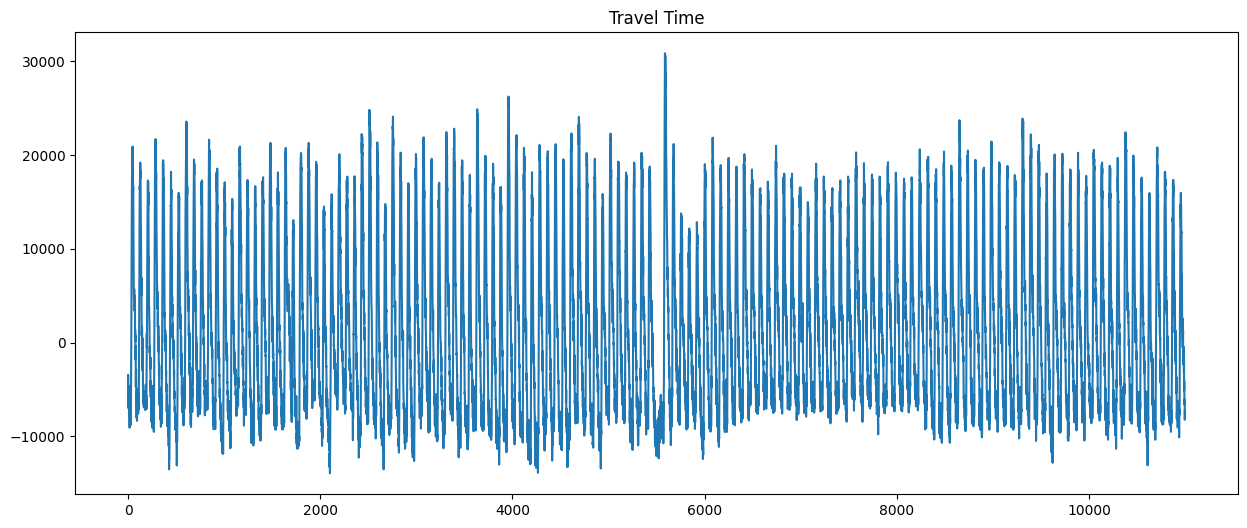

In [3]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
df_1 = np.genfromtxt('/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/094_UCR_Anomaly_NOISEBIDMC1_2500_5400_5600.txt')
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = 'Travel Time', legend = False);
#plt.plot()

In [4]:
df

,value
0,-4212.7637
1,-3438.2873
2,-4704.5428
3,-6975.8217
4,-6304.1302
...,...
10995,-6604.4306
10996,-6067.5663
10997,-6577.1845
10998,-8221.0213


In [5]:
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)

82

In [6]:
n = 20
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[82, 83, 81, 80, 80, 79, 81, 41, 41, 41, 83, 40, 40, 40, 41, 40, 27, 42, 85, 79]
[0.01218181818181818, 0.01209090909090909, 0.012363636363636363, 0.012454545454545454, 0.012545454545454545, 0.012636363636363635, 0.012272727272727272, 0.024454545454545455, 0.024272727272727272, 0.02418181818181818, 0.011999999999999999, 0.02509090909090909, 0.024999999999999998, 0.02518181818181818, 0.024636363636363633, 0.02490909090909091, 0.03654545454545454, 0.02409090909090909, 0.011818181818181818, 0.012727272727272726]


In [7]:
plt.figure()
plt.semilogy((1/f), px)
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

NameError: name 'plt' is not defined

## Model Training

In order to make the algorithm to work I will use Hyperparameters mentioned in the paper as much as possible. In case no values are provided, I will be hard coding those.

![](data/DeepAnt.png)

In this case, I will be using Sequence Length of 10, and Forecasting Horizon (P_w) 1. The Convolution Blocks use 32 filters, 3x3 Conv Kernel and 2x2 MaxPooling. Fully Connected Layer uses a 40 Units Hidden Layer before Ouptut.

The Model is Trained with MAE Loss (L1Loss in Pytorch) during 30 epochs.



In [ ]:
SEQ_LEN = 82*10
dataset = TrafficDataset(df, SEQ_LEN)
target_idx = dataset.timestamp # Timestamps to detect where the Anomaly Happens
X, y = dataset[0]
X.shape, y.shape, len(dataset) # Checking Sizes are compatible...


In [ ]:
model = DeepAnt(SEQ_LEN, 1)
sample = torch.randn(32,1,SEQ_LEN)

model(sample).shape

In [ ]:
model = DeepAnt(SEQ_LEN, 1)
anomaly_detector = AnomalyDetector(model)
dm = DataModule(df, SEQ_LEN)
mc = ModelCheckpoint(
    dirpath = 'checkpoints1',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'DeepAnt-best-checkpoint'
summary(model)

In [ ]:
trainer = pl.Trainer(max_epochs=30,
                    #accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

In [ ]:
anomaly_detector = AnomalyDetector.load_from_checkpoint('checkpoints1/DeepAnt-best-checkpoint.ckpt',model = model)

In [ ]:
output = trainer.predict(anomaly_detector, dm)
preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)

# Finding Threshold

After checking the Loss Distribution, the Threshold chose for detecting anomaly wat set to 0.5

In [ ]:
THRESHOLD = 0.4
plot_predictions(preds_losses, THRESHOLD)

## Detected Anomalies

In [ ]:
loss_plot(preds_losses, THRESHOLD)

print('Anomalies Detected: ')
preds_losses.loc[lambda x: x > THRESHOLD]

## Showing Anomalies in Context

In [ ]:
ts_plot(df, preds_losses, THRESHOLD)

## Looking Closer

In [ ]:
ts_plot(df, preds_losses, THRESHOLD)

In [ ]:
plt.plot(preds_losses)

In [ ]:
preds_losses

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
range = None
preds = preds_losses
threshold = THRESHOLD
idx = preds.loc[lambda x: x > threshold].index
plt.figure(figsize = (20,8))
if range is not None:
    min, max = range
    df = df[min:max]
plt.plot(df, label = '_nolegend_')
#plt.scatter(idx, df.loc[idx], color = 'red', label = 'Detected Anomalies by DeepAnt')
plt.scatter(anomaly, df.loc[anomaly], color = 'red', label = 'Anomalies')
plt.title('Detected Anomalies in Time Series')
plt.legend()
plt.show();

In [ ]:
anomaly = [i for i  in np.arange(5400, 5601)]

In [ ]:
np.arange(5400, 5600)